In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score
import math

from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from time import time
import time 
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.svm import  SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.ensemble import BaggingRegressor, AdaBoostRegressor, VotingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn import metrics

In [2]:
sample_submission = pd.read_csv("sample_submission.csv")
test = pd.read_csv("test.csv")
train = pd.read_csv("train.csv")

c_test  = test.copy()
c_train  = train.copy()

In [3]:
c_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
c_test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


The dataset has 81 columns, our target variable is SalePrice. ID is just an index that we can deop but we need it in the final submission also we have many missing values. Overall we have 79 features in our dataset.

We will create a new column in the both the dataframes and assign '1' and '0' values to all the rows which will be used to indicate that the rows belongs to train set or test set. Then we concat both the dataframes vertically (axis=0). Also we have mentioned 'sort=False' which means it prevents sorting of the columns.

In [5]:
c_train['train']  = 1
c_test['train']  = 0
df = pd.concat([c_train, c_test], axis=0,sort=False)

In [6]:
NAN = [(c, df[c].isna().mean()*100) for c in df]
NAN = pd.DataFrame(NAN, columns=["column_name", "percentage"])

Here we have created a list which will iterate over every column **'c'** in the dataframe **'df'** and for each column it calculates the percentage of missing values by using **'isna()'** function to create a **boolean mask** where missing values are True and then applying **'mean()'** to get the proportion of missing values. Multiplying by 100 converts this to percentage. The result is a **list of tuples**, where each tuple contains the column name (c) and the percentage of missing values in that column.<br>
The next line converts the list of tuples into a pandas dataframe. This new dataframe has two columns, **"column_name"** which contains names of column in 'df' and **"percentage"** which contains the percentage of missing values in each column.

In [7]:
NAN = NAN[NAN.percentage > 50]
NAN.sort_values("percentage", ascending=False)

,column_name,percentage
72,PoolQC,99.657417
74,MiscFeature,96.402878
6,Alley,93.216855
73,Fence,80.438506
25,MasVnrType,60.500171


We have filtered the dataframe to keep only those rows which have missing values percentage more than **50%**, then we have sort it in **descending order** with respect to the percentage column. This operation rearranges the rows such that the rows with the highest percentage of missing values appear at the top. As there are only 5 columns with more than 50% missing values, we will drop these columns from the dataframe.

In [8]:
df = df.drop(['Alley','PoolQC','Fence','MiscFeature'],axis=1)

Next we will seperate the object and numerical columns as both of these columns requires seperate processing and analysis method.

In [9]:
object_columns_df = df.select_dtypes(include=['object'])
numerical_columns_df =df.select_dtypes(exclude=['object'])

In [10]:
object_columns_df.dtypes

MSZoning         object
Street           object
LotShape         object
LandContour      object
Utilities        object
LotConfig        object
LandSlope        object
Neighborhood     object
Condition1       object
Condition2       object
BldgType         object
HouseStyle       object
RoofStyle        object
RoofMatl         object
Exterior1st      object
Exterior2nd      object
MasVnrType       object
ExterQual        object
ExterCond        object
Foundation       object
BsmtQual         object
BsmtCond         object
BsmtExposure     object
BsmtFinType1     object
BsmtFinType2     object
Heating          object
HeatingQC        object
CentralAir       object
Electrical       object
KitchenQual      object
Functional       object
FireplaceQu      object
GarageType       object
GarageFinish     object
GarageQual       object
GarageCond       object
PavedDrive       object
SaleType         object
SaleCondition    object
dtype: object

In [11]:
numerical_columns_df.dtypes

Id                 int64
MSSubClass         int64
LotFrontage      float64
LotArea            int64
OverallQual        int64
OverallCond        int64
YearBuilt          int64
YearRemodAdd       int64
MasVnrArea       float64
BsmtFinSF1       float64
BsmtFinSF2       float64
BsmtUnfSF        float64
TotalBsmtSF      float64
1stFlrSF           int64
2ndFlrSF           int64
LowQualFinSF       int64
GrLivArea          int64
BsmtFullBath     float64
BsmtHalfBath     float64
FullBath           int64
HalfBath           int64
BedroomAbvGr       int64
KitchenAbvGr       int64
TotRmsAbvGrd       int64
Fireplaces         int64
GarageYrBlt      float64
GarageCars       float64
GarageArea       float64
WoodDeckSF         int64
OpenPorchSF        int64
EnclosedPorch      int64
3SsnPorch          int64
ScreenPorch        int64
PoolArea           int64
MiscVal            int64
MoSold             int64
YrSold             int64
SalePrice        float64
train              int64
dtype: object

We will count the null values in each object type columns and fill it will **'None'**.

In [12]:
null_counts = object_columns_df.isnull().sum()
print("Number of null values in each column:\n{}".format(null_counts))

Number of null values in each column:
MSZoning            4
Street              0
LotShape            0
LandContour         0
Utilities           2
LotConfig           0
LandSlope           0
Neighborhood        0
Condition1          0
Condition2          0
BldgType            0
HouseStyle          0
RoofStyle           0
RoofMatl            0
Exterior1st         1
Exterior2nd         1
MasVnrType       1766
ExterQual           0
ExterCond           0
Foundation          0
BsmtQual           81
BsmtCond           82
BsmtExposure       82
BsmtFinType1       79
BsmtFinType2       80
Heating             0
HeatingQC           0
CentralAir          0
Electrical          1
KitchenQual         1
Functional          2
FireplaceQu      1420
GarageType        157
GarageFinish      159
GarageQual        159
GarageCond        159
PavedDrive          0
SaleType            1
SaleCondition       0
dtype: int64


In [13]:
columns_None = ['BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','GarageType','GarageFinish','GarageQual','FireplaceQu','GarageCond']
object_columns_df[columns_None]= object_columns_df[columns_None].fillna('None')

In [14]:
columns_with_lowNA = ['MSZoning','Utilities','Exterior1st','Exterior2nd','MasVnrType','Electrical','KitchenQual','Functional','SaleType']
object_columns_df[columns_with_lowNA] = object_columns_df[columns_with_lowNA].fillna(object_columns_df.mode().iloc[0])

For numerical type columns we will check the null values and fill them with the **median** of the entire column.

In [15]:
null_counts = numerical_columns_df.isnull().sum()
print("Number of null values in each column:\n{}".format(null_counts))

Number of null values in each column:
Id                  0
MSSubClass          0
LotFrontage       486
LotArea             0
OverallQual         0
OverallCond         0
YearBuilt           0
YearRemodAdd        0
MasVnrArea         23
BsmtFinSF1          1
BsmtFinSF2          1
BsmtUnfSF           1
TotalBsmtSF         1
1stFlrSF            0
2ndFlrSF            0
LowQualFinSF        0
GrLivArea           0
BsmtFullBath        2
BsmtHalfBath        2
FullBath            0
HalfBath            0
BedroomAbvGr        0
KitchenAbvGr        0
TotRmsAbvGrd        0
Fireplaces          0
GarageYrBlt       159
GarageCars          1
GarageArea          1
WoodDeckSF          0
OpenPorchSF         0
EnclosedPorch       0
3SsnPorch           0
ScreenPorch         0
PoolArea            0
MiscVal             0
MoSold              0
YrSold              0
SalePrice        1459
train               0
dtype: int64


To get the effective age of the house we have subtracted the **"YrSold"** and **"YrBuilt"** and get the median of it. The missing values in the "GarageYrBlt" column is filled with **"YrSold" - median**. For **"LotFrontage"** column the missing values are filled with the columns median. And rest of the numerical columns missing values are filled with 0.

In [16]:
print((numerical_columns_df['YrSold']-numerical_columns_df['YearBuilt']).median())
print(numerical_columns_df["LotFrontage"].median())

35.0
68.0


In [17]:
numerical_columns_df['GarageYrBlt'] = numerical_columns_df['GarageYrBlt'].fillna(numerical_columns_df['YrSold']-35)
numerical_columns_df['LotFrontage'] = numerical_columns_df['LotFrontage'].fillna(68)

In [18]:
numerical_columns_df= numerical_columns_df.fillna(0)

Utilities
AllPub    2918
NoSeWa       1
Name: count, dtype: int64

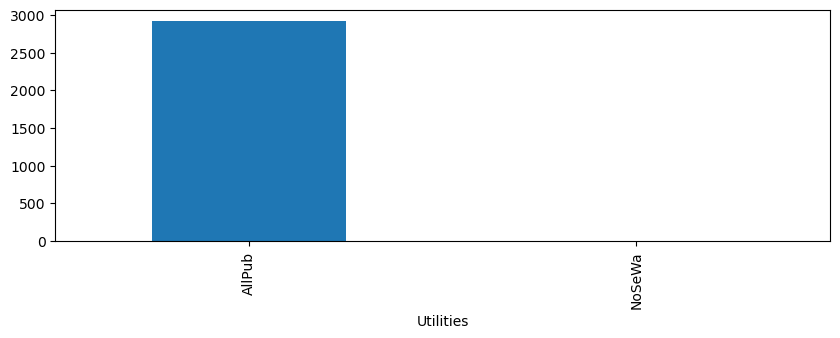

In [19]:
object_columns_df['Utilities'].value_counts().plot(kind='bar',figsize=[10,3])
object_columns_df['Utilities'].value_counts()

Street
Pave    2907
Grvl      12
Name: count, dtype: int64

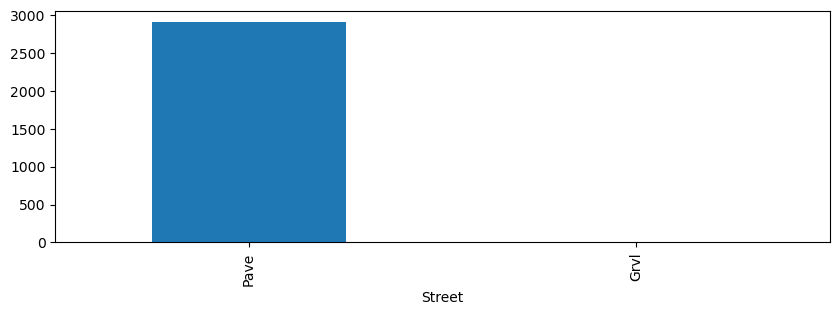

In [20]:
object_columns_df['Street'].value_counts().plot(kind='bar',figsize=[10,3])
object_columns_df['Street'].value_counts() 

Condition2
Norm      2889
Feedr       13
Artery       5
PosN         4
PosA         4
RRNn         2
RRAn         1
RRAe         1
Name: count, dtype: int64

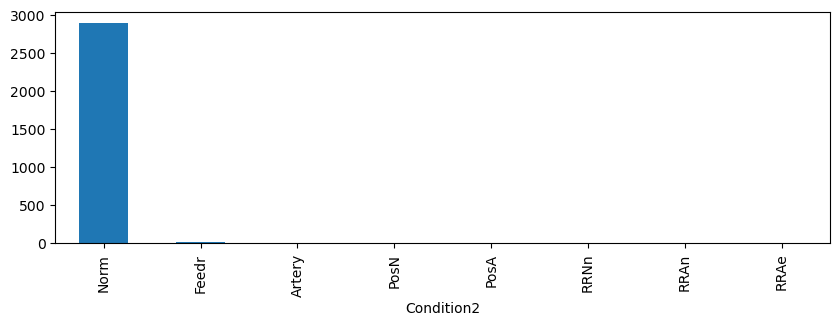

In [21]:
object_columns_df['Condition2'].value_counts().plot(kind='bar',figsize=[10,3])
object_columns_df['Condition2'].value_counts() 

RoofMatl
CompShg    2876
Tar&Grv      23
WdShake       9
WdShngl       7
Metal         1
Membran       1
Roll          1
ClyTile       1
Name: count, dtype: int64

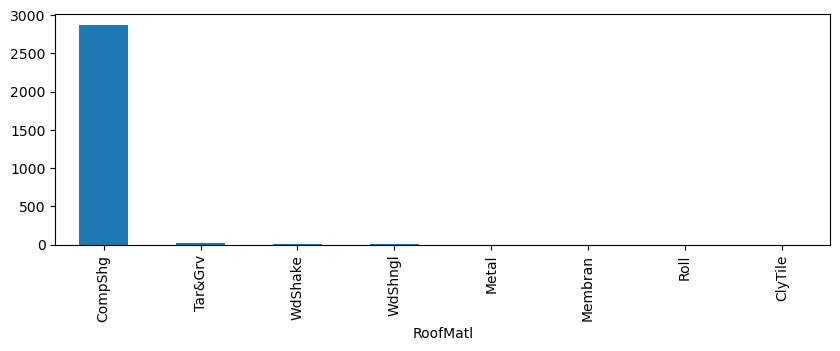

In [22]:
object_columns_df['RoofMatl'].value_counts().plot(kind='bar',figsize=[10,3])
object_columns_df['RoofMatl'].value_counts()

Heating
GasA     2874
GasW       27
Grav        9
Wall        6
OthW        2
Floor       1
Name: count, dtype: int64

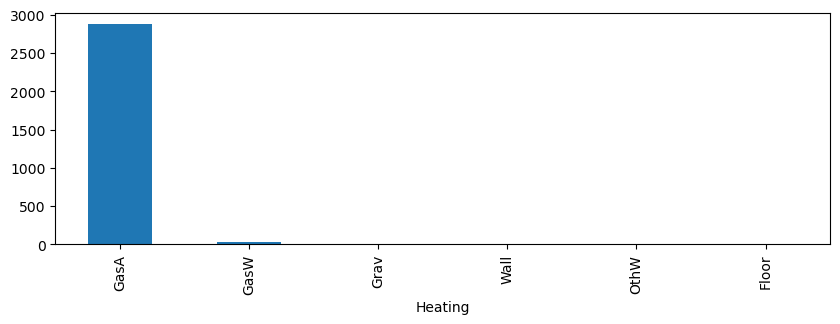

In [23]:
object_columns_df['Heating'].value_counts().plot(kind='bar',figsize=[10,3])
object_columns_df['Heating'].value_counts()

After making some plots we found that some columns have low variance so we will drop them.

In [24]:
object_columns_df = object_columns_df.drop(['Heating','RoofMatl','Condition2','Street','Utilities'],axis=1)

We add a new column **"Age_House"** which is the difference of "YrSold" and "YrBuilt".

In [25]:
numerical_columns_df['Age_House']= (numerical_columns_df['YrSold']-numerical_columns_df['YearBuilt'])
numerical_columns_df['Age_House'].describe()

count    2919.000000
mean       36.479959
std        30.336182
min        -1.000000
25%         7.000000
50%        35.000000
75%        54.500000
max       136.000000
Name: Age_House, dtype: float64

As age cannot be negative we will verify that ther should not be any value in the Age_House column that is negative.

In [26]:
Negatif = numerical_columns_df[numerical_columns_df['Age_House'] < 0]
Negatif

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice,train,Age_House
1089,2550,20,128.0,39290,10,5,2008,2009,1224.0,4010.0,...,0,0,0,0,17000,10,2007,0.0,0,-1


We will replace the values of "YrSold" that has caused the negative age value to **2009** so that the minimum value now becomes 0. As it does not make sense that the house sold in 2007 base built in 2009.

In [27]:
numerical_columns_df.loc[numerical_columns_df['YrSold'] < numerical_columns_df['YearBuilt'],'YrSold' ] = 2009
numerical_columns_df['Age_House']= (numerical_columns_df['YrSold']-numerical_columns_df['YearBuilt'])
numerical_columns_df['Age_House'].describe()

count    2919.000000
mean       36.480644
std        30.335358
min         0.000000
25%         7.000000
50%        35.000000
75%        54.500000
max       136.000000
Name: Age_House, dtype: float64

TotalBsmtBath : Sum of : BsmtFullBath and 1/2 BsmtHalfBath <br>
TotalBath : Sum of : FullBath and 1/2 HalfBath<br>
TotalSA : Sum of : 1stFlrSF and 2ndFlrSF and basement area<br>

In [28]:
numerical_columns_df['TotalBsmtBath'] = numerical_columns_df['BsmtFullBath'] + numerical_columns_df['BsmtFullBath']*0.5
numerical_columns_df['TotalBath'] = numerical_columns_df['FullBath'] + numerical_columns_df['HalfBath']*0.5 
numerical_columns_df['TotalSA']=numerical_columns_df['TotalBsmtSF'] + numerical_columns_df['1stFlrSF'] + numerical_columns_df['2ndFlrSF']

In [29]:
numerical_columns_df.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,PoolArea,MiscVal,MoSold,YrSold,SalePrice,train,Age_House,TotalBsmtBath,TotalBath,TotalSA
0,1,60,65.0,8450,7,5,2003,2003,196.0,706.0,...,0,0,2,2008,208500.0,1,5,1.5,2.5,2566.0
1,2,20,80.0,9600,6,8,1976,1976,0.0,978.0,...,0,0,5,2007,181500.0,1,31,0.0,2.0,2524.0
2,3,60,68.0,11250,7,5,2001,2002,162.0,486.0,...,0,0,9,2008,223500.0,1,7,1.5,2.5,2706.0
3,4,70,60.0,9550,7,5,1915,1970,0.0,216.0,...,0,0,2,2006,140000.0,1,91,1.5,1.0,2473.0
4,5,60,84.0,14260,8,5,2000,2000,350.0,655.0,...,0,0,12,2008,250000.0,1,8,1.5,2.5,3343.0


## Encoding Categorical Features
It is a process that converts categorical (labelled) data into a numerical format that can be use to built ML models. There are different types of encoding that can be applied :- <br>
**1. Label Encoding:** This method assigns a unique integer to each category. For example, in a binary feature like "gender" (male, female), you could use 0 and 1 for encoding.

**2. One-Hot Encoding:** This method creates a new binary feature for each category. Each binary feature represents the presence or absence of a category. For example, "gender" would be converted into two binary features: "is_male" and "is_female."

**3. Ordinal Encoding:** This method is used when there is an inherent order in the categories. Each category is assigned a value based on its order. For example, "low," "medium," and "high" could be encoded as 0, 1, and 2, respectively.

**4. Binary Encoding:** This method first converts categories into integers and then converts those integers into binary code. Each binary digit represents a different category.

**5. Hashing Encoding:** This method uses a hash function to convert categories into a hash value, which is then used as the encoded value. It's useful when dealing with high cardinality categorical features.

In [30]:
bin_map  = {'TA':2,'Gd':3, 'Fa':1,'Ex':4,'Po':1,'None':0,'Y':1,'N':0,'Reg':3,'IR1':2,'IR2':1,'IR3':0,"None" : 0,
            "No" : 2, "Mn" : 2, "Av": 3,"Gd" : 4,"Unf" : 1, "LwQ": 2, "Rec" : 3,"BLQ" : 4, "ALQ" : 5, "GLQ" : 6
            }
object_columns_df['ExterQual'] = object_columns_df['ExterQual'].map(bin_map)
object_columns_df['ExterCond'] = object_columns_df['ExterCond'].map(bin_map)
object_columns_df['BsmtCond'] = object_columns_df['BsmtCond'].map(bin_map)
object_columns_df['BsmtQual'] = object_columns_df['BsmtQual'].map(bin_map)
object_columns_df['HeatingQC'] = object_columns_df['HeatingQC'].map(bin_map)
object_columns_df['KitchenQual'] = object_columns_df['KitchenQual'].map(bin_map)
object_columns_df['FireplaceQu'] = object_columns_df['FireplaceQu'].map(bin_map)
object_columns_df['GarageQual'] = object_columns_df['GarageQual'].map(bin_map)
object_columns_df['GarageCond'] = object_columns_df['GarageCond'].map(bin_map)
object_columns_df['CentralAir'] = object_columns_df['CentralAir'].map(bin_map)
object_columns_df['LotShape'] = object_columns_df['LotShape'].map(bin_map)
object_columns_df['BsmtExposure'] = object_columns_df['BsmtExposure'].map(bin_map)
object_columns_df['BsmtFinType1'] = object_columns_df['BsmtFinType1'].map(bin_map)
object_columns_df['BsmtFinType2'] = object_columns_df['BsmtFinType2'].map(bin_map)

PavedDrive =   {"N" : 0, "P" : 1, "Y" : 2}
object_columns_df['PavedDrive'] = object_columns_df['PavedDrive'].map(PavedDrive)

Here we have created a dictionary that maps the categorical values to the numerical values. Each column of **'object_columns_df'** maps to a specific numerical values based on **'bin_map'**.

In [31]:
rest_object_columns = object_columns_df.select_dtypes(include=['object'])
object_columns_df = pd.get_dummies(object_columns_df, columns=rest_object_columns.columns) 

The **rest_object_columns** contains columns from the dataframe which contains object dtype that is **categorical** columns. **get_dummies()** function converts categorical variables into **dummy/indicator** variables (binary values 0 or 1) through a the one-hot encoding.

In [32]:
object_columns_df.head()

,LotShape,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,HeatingQC,CentralAir,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,3,4,2,4,2,2,6,1,4,1,...,False,False,False,True,False,False,False,False,True,False
1,3,2,2,4,2,4,5,1,4,1,...,False,False,False,True,False,False,False,False,True,False
2,2,4,2,4,2,2,6,1,4,1,...,False,False,False,True,False,False,False,False,True,False
3,2,2,2,2,4,2,5,1,4,1,...,False,False,False,True,True,False,False,False,False,False
4,2,4,2,4,2,3,6,1,4,1,...,False,False,False,True,False,False,False,False,True,False


After this we concat the categorical and numerical columns to get our final cleaned dataframe.

In [33]:
df_final = pd.concat([object_columns_df, numerical_columns_df], axis=1,sort=False)
df_final.head()

,LotShape,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,HeatingQC,CentralAir,...,PoolArea,MiscVal,MoSold,YrSold,SalePrice,train,Age_House,TotalBsmtBath,TotalBath,TotalSA
0,3,4,2,4,2,2,6,1,4,1,...,0,0,2,2008,208500.0,1,5,1.5,2.5,2566.0
1,3,2,2,4,2,4,5,1,4,1,...,0,0,5,2007,181500.0,1,31,0.0,2.0,2524.0
2,2,4,2,4,2,2,6,1,4,1,...,0,0,9,2008,223500.0,1,7,1.5,2.5,2706.0
3,2,2,2,2,4,2,5,1,4,1,...,0,0,2,2006,140000.0,1,91,1.5,1.0,2473.0
4,2,4,2,4,2,3,6,1,4,1,...,0,0,12,2008,250000.0,1,8,1.5,2.5,3343.0


Then we will drop the ID column and using the values 0 and 1 that we specified for training and testing rows, we can seperate the data into train and test dataframes. Also we will seperate the target column **'SalePrice'** from the train dataframe. And further we will spilt the train data into **train** and **validation**.

In [34]:
df_final = df_final.drop(['Id',],axis=1)

df_train = df_final[df_final['train'] == 1]
df_train = df_train.drop(['train',],axis=1)

df_test = df_final[df_final['train'] == 0]
df_test = df_test.drop(['SalePrice'],axis=1)
df_test = df_test.drop(['train',],axis=1)

In [35]:
target= df_train['SalePrice']
df_train = df_train.drop(['SalePrice'],axis=1)

In [36]:
X_train,X_val,y_train,y_val = train_test_split(df_train,target,test_size=0.33,random_state=0)

In [37]:
def acc_summary(pipeline, X_train, y_train, X_val, y_val):
    sentiment_fit = pipeline.fit(X_train, y_train)
    y_pred = sentiment_fit.predict(X_val)
    rmse = math.sqrt(metrics.mean_squared_error(y_val, y_pred))
    print("root mean squre error : {0:.2f}".format(rmse))
    print("-"*80)
    return rmse

We pass the train data through a **pipeline which will train our ML models to this data. Then we can use the trained pipeline to predict the values for validation and test data. To get the **loss** between actual values and predicted values we have define it using **Root Mean Squared Error (RMSE)**. This loss function will measure the model's performace, indicating how closely the predicted values match the actual values. 

In [38]:
names = [ 
        'Gradient Boosting Regressor',  
        "Bagging Regressor",
        "AdaBoost Regressor", 
        "K Nearest Neighbour Regressor",
         "Decison Tree Regressor",
         "Random Forest Regressor",
        "Gaussian Process Regressor",
        "XGB Regressor",
        "LGBM Regressor"
         ]
regressors = [
    
    GradientBoostingRegressor(), 
    BaggingRegressor(),
    AdaBoostRegressor(),
    KNeighborsRegressor(),
    DecisionTreeRegressor(),
    RandomForestRegressor(),
    GaussianProcessRegressor(),
    XGBRegressor( booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.6, gamma=0,
             importance_type='gain', learning_rate=0.02, max_delta_step=0,
             max_depth=4, min_child_weight=1.5, n_estimators=2000,
             n_jobs=1, nthread=None, objective='reg:linear',
             reg_alpha=0.6, reg_lambda=0.6, scale_pos_weight=1, 
             silent=None, subsample=0.8, verbosity=1),
     LGBMRegressor(objective='regression', 
                                       num_leaves=4, #was 3
                                       learning_rate=0.01, 
                                       n_estimators=11000, #8000
                                       max_bin=200, 
                                       bagging_fraction=0.75,
                                       bagging_freq=5, 
                                       bagging_seed=7,
                                       feature_fraction=0.4, # 'was 0.2'
                                       )

        ]

zipped_clf = zip(names,regressors)

First we have define a list of all the regression model that we want to use and further each model is initialized with specific hyperparameters and settings that define the behaviour of the model during training and prediction. The zip function is used to combine the names **list** and **regressor** list into a **single iterable object**, where each element in this object will be a tuple containing name and regression model **instance**.

In [39]:
def regressor_comparator(X_train,y_train,X_val,y_val,regressor=zipped_clf): 
    result = []
    for n,r in regressor:
        checker_pipeline = Pipeline([
            ('regressor', r)
        ])
        print("Validation result for {}".format(n))
        clf_acc= acc_summary(checker_pipeline,X_train, y_train, X_val, y_val)
        result.append((n,clf_acc))
    return result

This function evaluates and compares the performance of differnt regression models, helping to identify the most suitable model for a given regression task. Every model is passed thorugh the pipeline and their loss is calculated and appended as a tuple to the result list as **(validation_result, RMSE)** for each model.

In [40]:
regressor_comparator(X_train,y_train,X_val,y_val)

Validation result for Gradient Boosting Regressor
root mean squre error : 28547.61
--------------------------------------------------------------------------------
Validation result for Bagging Regressor
root mean squre error : 30427.96
--------------------------------------------------------------------------------
Validation result for AdaBoost Regressor
root mean squre error : 35613.00
--------------------------------------------------------------------------------
Validation result for K Nearest Neighbour Regressor
root mean squre error : 44926.15
--------------------------------------------------------------------------------
Validation result for Decison Tree Regressor
root mean squre error : 43106.86
--------------------------------------------------------------------------------
Validation result for Random Forest Regressor
root mean squre error : 30383.44
--------------------------------------------------------------------------------
Validation result for Gaussian Process Reg

C:\Users\sayed\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [23:19:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


root mean squre error : 26135.04
--------------------------------------------------------------------------------
Validation result for LGBM Regressor
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overh

[('Gradient Boosting Regressor', 28547.607006286635),
 ('Bagging Regressor', 30427.96379944631),
 ('AdaBoost Regressor', 35612.99959127167),
 ('K Nearest Neighbour Regressor', 44926.15065463992),
 ('Decison Tree Regressor', 43106.861255619195),
 ('Random Forest Regressor', 30383.436825255754),
 ('Gaussian Process Regressor', 197001.73583843268),
 ('XGB Regressor', 26135.043101165058),
 ('LGBM Regressor', 26908.016693722187)]